In [1]:
import pandas as pd
from scipy.stats import levene, kruskal

Варіант №7:
* Фактор А - Географічне розташування в межах частини світу;
* Частина світу або країни - Південна, центральна, північна частини Африки;
* Фактор В - Захворюваність.

[WHO-COVID-19-global-data.csv](https://covid19.who.int/WHO-COVID-19-global-data.csv)

Крок 0. Готуємо DataFrame з даними відповідно до завдання:

In [2]:
# Дістаємо тільки необхідні колонки і парсимо колонку з датою.
column_names = ["Date_reported", "Country_code", "New_cases"]
df = pd.read_csv("sample_data/WHO-COVID-19-global-data.csv",
                 usecols=column_names,
                 parse_dates=["Date_reported"],
                 infer_datetime_format=True)

# Відкидаємо зайві дати
from_date = pd.Timestamp(2020, 3, 1)
to_date = pd.Timestamp(2021, 11, 30)
df = df[(df["Date_reported"] > from_date) & (df["Date_reported"] <= to_date)]

# Видобуваємо лише дані для країн, які задані варіантом
# Приналежність до певного регіону та коди країн взяті з
# https://en.wikipedia.org/wiki/United_Nations_geoscheme_for_Africa
countries = {
    "code": [
        "DZ", "EG", "LY", "MA", "SD", "TN", "EH",
        "AO", "CM", "CF", "TD", "CG", "CD", "GQ", "GA", "ST",
        "BW", "SZ", "LS", "NA", # "ZA"
    ], 
    "name": [
        "Algeria", "Egypt", "Libya", "Morocco", "Sudan", "Tunisia",
        "Western Sahara",

        "Angola", "Cameroon", "Central African Republic", "Chad",
        "Republic of the Congo", "Democratic Republic of the Congo",
        "Equatorial Guinea", "Gabon", "São Tomé and Príncipe",
        
        "Botswana", "Eswatini", "Lesotho", "Namibia",  # "South Africa"
    ],
    "region":
        ["Північна африка"] * 7 + 
        ["Центральна африка"] * 9 +
        ["Південна африка"] * 4
}
df_countries = pd.DataFrame(countries)
df = df[df["Country_code"].isin(df_countries.code)]

# Конвертуємо код країни в назву та регіон і додаємо як нові колонки.
df["Country_name"] = df["Country_code"].map(dict(zip(countries["code"], countries["name"])))
df["Region"] = df["Country_code"].map(dict(zip(countries["code"], countries["region"])))

Крок 1. Обчислюєм суму захворювань для кожної країни помісячно:

In [3]:
df.groupby([(df.Date_reported.dt.year), (df.Date_reported.dt.month), (df.Country_code)])['New_cases'].sum()

Date_reported  Date_reported  Country_code
2020           3              AO                 4
                              BW                 3
                              CD                98
                              CF                13
                              CG                19
                                              ... 
2021           11             SD              2311
                              ST                19
                              SZ               169
                              TD                38
                              TN              4728
Name: New_cases, Length: 378, dtype: int64

Крок 2. Обчислємо середнє значення кількості захворювань за кожен сезон:

In [4]:
def date_to_season(date_reported):
    month = date_reported.month
    year = date_reported.year

    if month == 3 or month == 4 or month == 5:
        return f"Весна {year}"
    elif month == 6 or month == 7 or month == 8:
        return f"Літо {year}"
    elif month == 9 or month == 10 or month == 11:
        return f"Осінь {year}"
    else:
        return f"Зима {year}"
df["Season"] = df["Date_reported"].apply(lambda x : date_to_season(x))


# Сортування за сезоном
mapping = {
    "Весна 2020": 0, "Літо 2020": 1, "Осінь 2020": 2, "Зима 2020": 3,
    "Весна 2021": 4, "Літо 2021": 5, "Осінь 2021": 6, "Зима 2021": 7
}
df_mapping = df_mapping = pd.DataFrame({"Season": mapping.keys()})
sort_mapping = df_mapping.reset_index().set_index("Season")
df["Season_num"] = df["Season"].map(sort_mapping["index"])

df.groupby("Season")["New_cases", "Season_num"].mean().sort_values("Season_num").drop(columns=["Season_num"]).reset_index()

/tmp/ipykernel_688/3106006001.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby("Season")["New_cases", "Season_num"].mean().sort_values("Season_num").drop(columns=["Season_num"]).reset_index()


,Season,New_cases
0,Весна 2020,38.552503
1,Літо 2020,143.111111
2,Осінь 2020,334.611722
3,Зима 2020,369.500000
4,Весна 2021,250.153382
5,Літо 2021,634.986715
6,Осінь 2021,252.784493
7,Зима 2021,283.501883


Крок 3. Обчислюємо середнє значення кількості захворювань по країнах в сезон і будуємо відповідний графік:

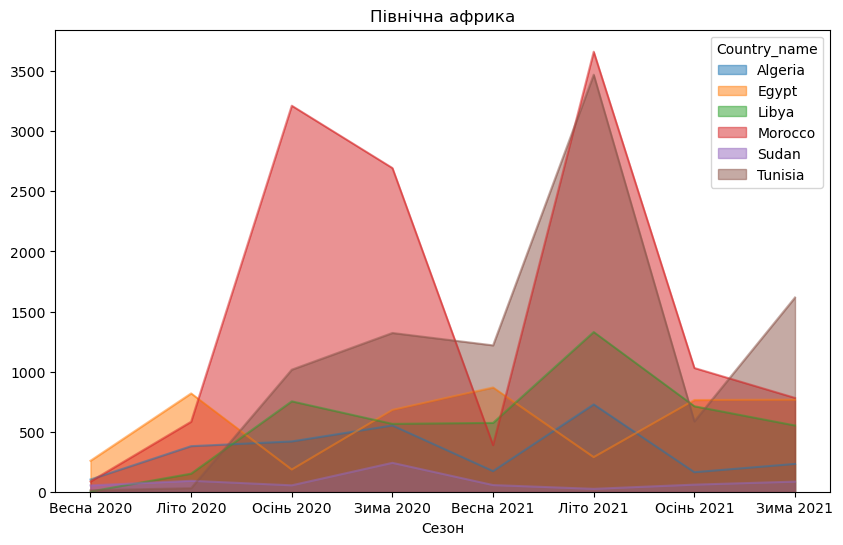

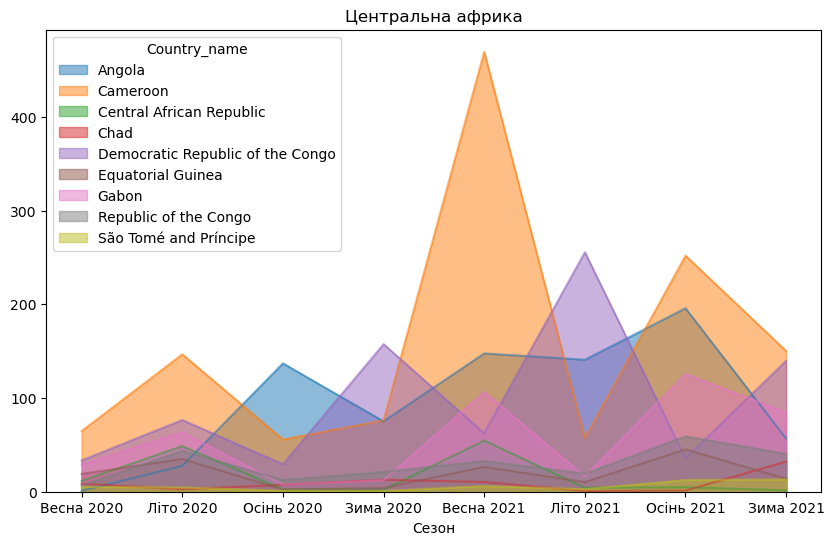

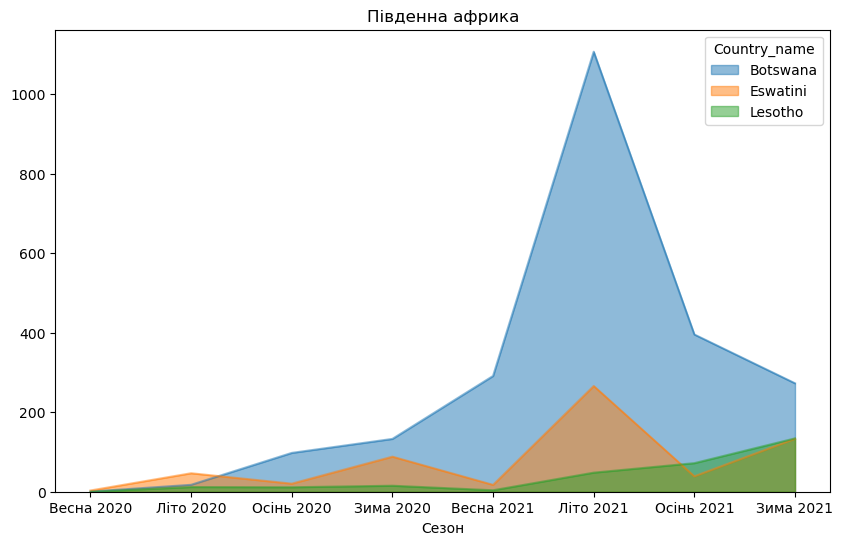

In [5]:
def average_cases(region):
    return df[df["Region"] == region] \
             .groupby(["Country_name", "Season"])["New_cases"] \
             .agg("mean") \
             .reset_index() \
             .pivot(index="Season", columns="Country_name", values="New_cases") \
             .sort_index(key=lambda x : x.map(mapping)) 

def plot_average_cases(region):
    average_cases(region).plot(
        title = region, kind="area", stacked=False, figsize=(10,6), xlabel="Сезон"
    )

plot_average_cases("Північна африка")
plot_average_cases("Центральна африка")
plot_average_cases("Південна африка")

Крок 4. Створюємо датафрейм з середніми показниками захворюваності регіонах і будуємо відповідний графік:

<AxesSubplot:title={'center':'Середнє значення захворювання'}, xlabel='Сезон'>

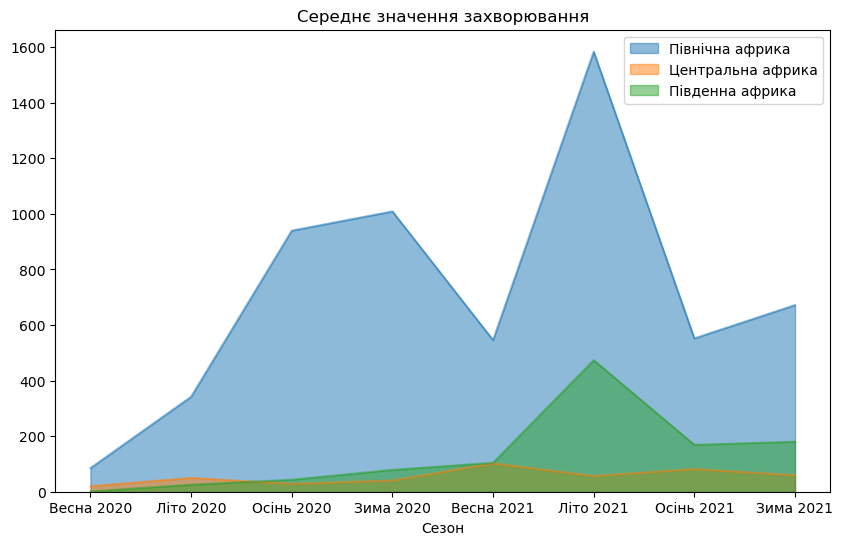

In [6]:
f1 = average_cases("Північна африка").mean(axis=1)
f2 = average_cases("Центральна африка").mean(axis=1)
f3 = average_cases("Південна африка").mean(axis=1)

df_average_by_regions = pd.DataFrame(
    zip(f1, f2, f3),
    index=df_mapping["Season"],
    columns=["Північна африка", "Центральна африка", "Південна африка"]
)

df_average_by_regions.plot(title = "Середнє значення захворювання", kind="area", stacked=False, figsize=(10,6), xlabel="Сезон")

Крок 5. За допомогою теста Левена перевіряємо чи дисперсії груп однакові

$H_0$ : $\sigma^2_1$ = $\sigma^2_2$ = $\sigma^2_3$

In [7]:
stat, p = levene(f1, f2, f3)

print("p =", round(p, 2))

kruskal(f1, f2, f3)

p = 0.01


KruskalResult(statistic=13.335000000000008, pvalue=0.0012715737149360362)

Висновок: так як в тесті Левена p < 0.05, ми відкидаємо гіпотезу $H_0$, бо дисперсії неоднакові й ми не можемо застосовувати параметричний дисперсійний аналіз. Тому застосовуємо непараметричний дисперсійний аналіз за крітерієм Краскел-Уоліса. Отримавши p < 0.05 маємо вплив фактора значущим, тобто географічне розшташування значно впливає на інфікованість.